**Data Fields**
* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* PhotoAmt - Total uploaded photos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

In [22]:
# libraries
!pip install langdetect
# ===============================
# 1. Системні та налаштування
# ===============================
import os
import gc
import time
import datetime
import random
import warnings
from functools import partial
from math import sqrt
from collections import Counter

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# ===============================
# 2. Робота з даними
# ===============================
import numpy as np
import pandas as pd
import scipy as sp

pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

# ===============================
# 3. Візуалізація
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from PIL import Image

py.init_notebook_mode(connected=True)
plt.style.use('ggplot')
%matplotlib inline

# ===============================
# 4. Machine Learning бібліотеки
# ===============================
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    mean_squared_error, 
    roc_auc_score, 
    cohen_kappa_score, 
    confusion_matrix as sk_cmatrix
)

# ===============================
# 5. NLP
# ===============================
from nltk.tokenize import TweetTokenizer
import langdetect

# ===============================
# 6. Інтерпретація моделей
# ===============================
import eli5
from IPython.display import display

# ===============================
# 7. Корисні функції
# ===============================
def kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

Отримуємо дані для датасету

In [23]:
breeds = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/breed_labels.csv')
colors = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/color_labels.csv')
states = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/state_labels.csv')

train = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/train/train.csv')
test = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/test/test.csv')
sub = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/test/sample_submission.csv')
submit = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/test/test.csv')

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])

In [24]:
print(os.listdir("../input/petfinder-adoption-prediction/"))

['state_labels.csv', 'train_metadata', 'color_labels.csv', 'StateLabels.csv', 'train_images', 'test_metadata', 'PetFinder-BreedLabels.csv', 'BreedLabels.csv', 'train_sentiment', 'ColorLabels.csv', 'test_sentiment', 'PetFinder-ColorLabels.csv', 'PetFinder-StateLabels.csv', 'test', 'train', 'breed_labels.csv', 'test_images']


In [25]:
train.drop('Description', axis=1).head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed,dataset_type
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1.0,2,train
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2.0,0,train
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7.0,3,train
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8.0,2,train
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3.0,2,train


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

In [27]:
# Перевіримо наявність пропусків
train.isnull().sum()

Type                0
Name             1265
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        13
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dataset_type        0
dtype: int64

Text(0.5, 1.0, 'Розподіл AdoptionSpeed')

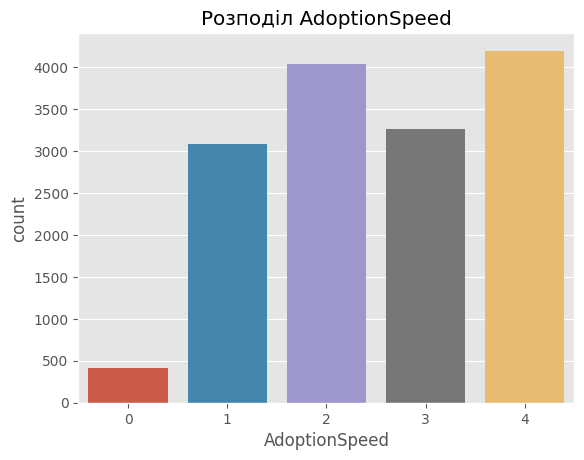

In [28]:
sns.countplot(data=train, x='AdoptionSpeed')
plt.title('Розподіл AdoptionSpeed')

1. Маємо розуміння, що за 7 діб тварини практично не знаходять домівку. Ці дані ми приймаємо як факт, без зміни.
2. Створюємо бінарну ознаку: HasName (чи є ім'я чи не має).
3. Заповнюємо порожні значення спеціальним тегом, наприклад "No description".

In [29]:
all_data['HasName'] = all_data['Name'].notnull().astype(int)
all_data['Description'] = all_data['Description'].fillna("No description")

Попередня обробка тексту для 'Description'

In [30]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # залишаємо лише букви
    return text

train['clean_description'] = train['Description'].apply(clean_text)
test['clean_description'] = test['Description'].apply(clean_text)


Обробка зображень (опціонально на цьому етапі)
У повній моделі зображення можна буде обробити через CNN (наприклад, ResNet з torchvision.models).

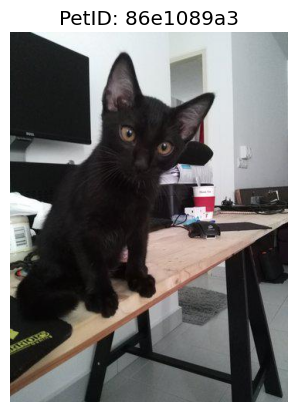

In [31]:
# приклад візуалізації зображення
example_pet_id = train['PetID'].iloc[0]
image_path = f"/kaggle/input/petfinder-adoption-prediction/train_images/{example_pet_id}-1.jpg"

img = Image.open(image_path)
plt.imshow(img)
plt.title(f"PetID: {example_pet_id}")
plt.axis('off')
plt.show()

Проводимо перетворення тексту у вектори (TF-IDF / Transformers)

In [32]:
tfidf = TfidfVectorizer(max_features=500)
tfidf_train = tfidf.fit_transform(train['clean_description'])
tfidf_test = tfidf.transform(test['clean_description'])


In [33]:
# Вибираємо фічі
features = ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt']
X = train[features]
y = train['AdoptionSpeed']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
score = cohen_kappa_score(y_val, y_pred, weights='quadratic')
print("Quadratic Kappa:", score)


Quadratic Kappa: 0.3684644471408951


не використовуємо: 
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)

Побудова базової моделі (LightGBM + тільки табличні дані)

Об'єднання табличних та текстових фіч

In [34]:
from scipy.sparse import hstack

X_combined = hstack([X_train, tfidf_train[:X_train.shape[0]]])
X_combined_val = hstack([X_val, tfidf_train[X_train.shape[0]:]])

model = lgb.LGBMClassifier()
model.fit(X_combined, y_train)

y_pred = model.predict(X_combined_val)
score = cohen_kappa_score(y_val, y_pred, weights='quadratic')
print("Kappa with text:", score)


Kappa with text: 0.3170647198549391


Покращення: Transfer Learning для тексту та зображень

In [35]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


 ResNet/VGG для зображень

In [36]:
from torchvision import models, transforms

resnet = models.resnet50(pretrained=True)
resnet.eval()  # вимикаємо тренування

# Перетворення зображення
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


Регулярна перевірка метрики

In [37]:
from sklearn.metrics import cohen_kappa_score

def kappa_score(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')


Побудова «портрету» тварини, яка має найвищі шанси на всиновлення

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Number of positive: 319, number of negative: 14853
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.864268
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.290587
[LightGBM] [Debug] init for col-wise cost 0.000616 seconds, init for row-wise cost 0.001983 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 439
[LightGBM] [Info] Number of data points in the train set: 15172, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021026 -> initscore=-3.840766
[LightGBM] [Info] Start training from score -3.840766
[Lig

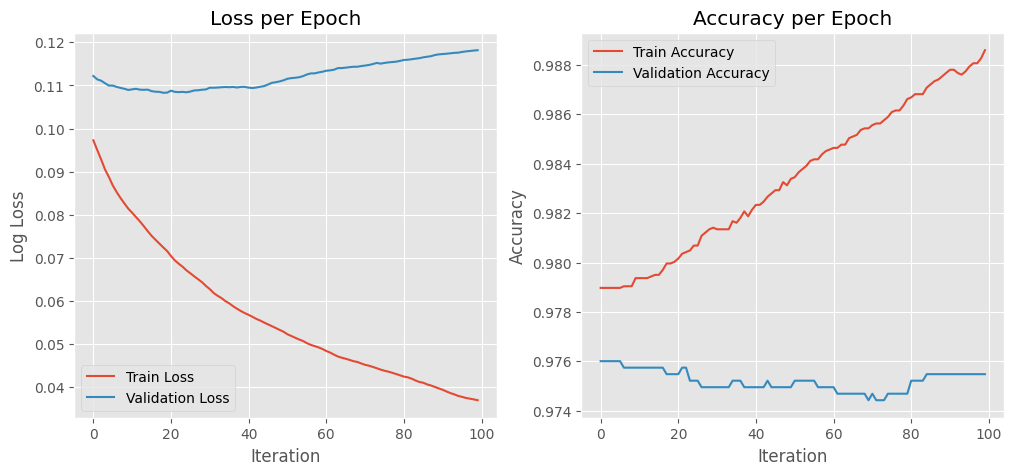

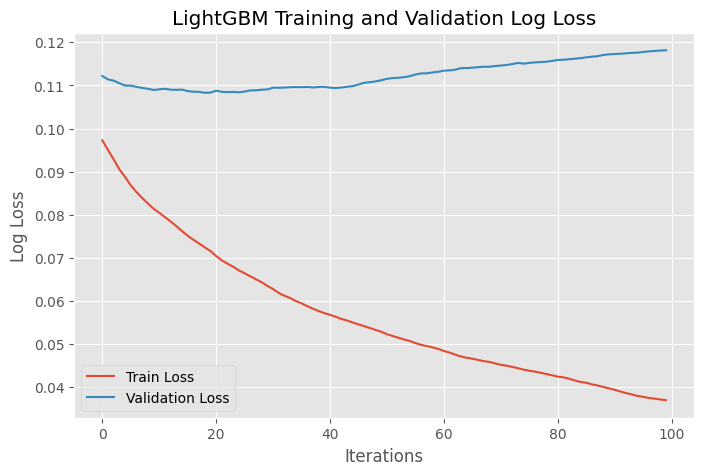

Важливість ознак:
 Age             581
PhotoAmt        451
Fee             213
FurLength       196
Breed1          185
Gender          179
MaturitySize    168
Quantity        154
Dewormed        154
Sterilized      133
Breed2          126
Vaccinated      119
Type             64
State            53
HasName          52
VideoAmt         49
Color2           47
Color1           41
Health           35
dtype: int32


In [38]:
# Розділимо тварин на 2 класи: швидко всиновлені (0) vs інші (1–4)
all_data['QuickAdoption'] = (all_data['AdoptionSpeed'] == 0).astype(int)

features = ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
            'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized',
            'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt', 'HasName']

X = all_data[features]
y = all_data['QuickAdoption']

categorical_features = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
                        'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
                        'Sterilized', 'Health', 'State', 'HasName']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

evals_result = {}

model = lgb.LGBMClassifier(random_state=42, verbose=10)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric=['binary_logloss', 'binary_error'],
    categorical_feature=categorical_features,
)

evals_result = model.evals_result_

# loss
train_loss = evals_result['training']['binary_logloss']
val_loss = evals_result['valid_1']['binary_logloss']

print("train_loss: ", train_loss)
print("val_loss: ", val_loss)

# accuracy (1 - error)
train_acc = [1 - x for x in evals_result['training']['binary_error']]
val_acc = [1 - x for x in evals_result['valid_1']['binary_error']]

# графік
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

# Отримуємо лоси з атрибуту evals_result_
train_loss = model.evals_result_['training']['binary_logloss']
val_loss = model.evals_result_['valid_1']['binary_logloss']

# Малюємо графіки
plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('LightGBM Training and Validation Log Loss')
plt.legend()
plt.show()
# Виводимо важливість ознак
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("Важливість ознак:\n", importances)



Додаємо stopping_rounds=5 означає, що якщо валідаційний loss не покращується 5 ітерацій, тренування зупиниться.

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0972669	training's binary_error: 0.0210256	valid_1's binary_logloss: 0.112177	valid_1's binary_error: 0.0239916
train_loss:  [0.09726692483446431, 0.09502250480321604, 0.092837491480024, 0.09052507777145498, 0.08876831511270315, 0.08681634100145263]
val_loss:  [0.11217748854096522, 0.11140557408640157, 0.11109653492685885, 0.1105040561215247, 0.10997175951051674, 0.10996167831772499]


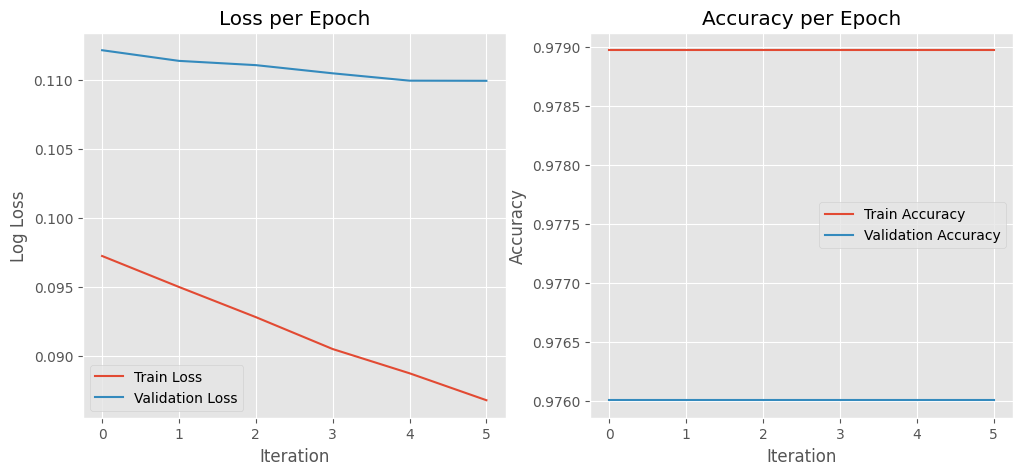

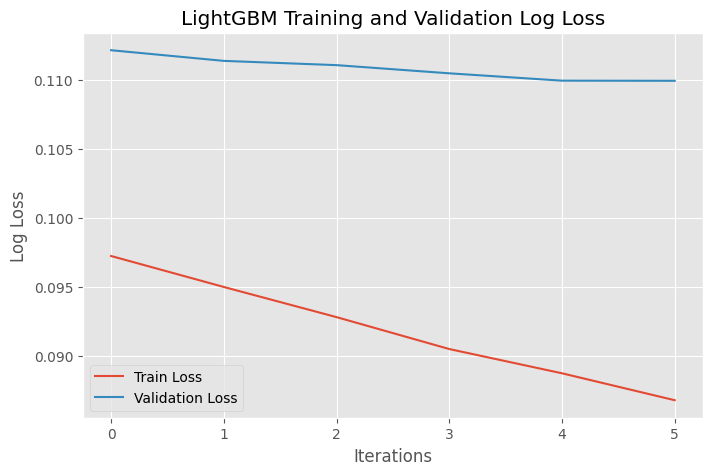

Важливість ознак:
 PhotoAmt        5
Age             4
Vaccinated      3
Gender          3
MaturitySize    3
Fee             2
Breed1          2
FurLength       2
Dewormed        2
Quantity        2
Breed2          1
Sterilized      1
VideoAmt        0
State           0
Type            0
Health          0
Color2          0
Color1          0
HasName         0
dtype: int32


In [39]:
from lightgbm import early_stopping
model = lgb.LGBMClassifier(random_state=42, verbose=-1)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric=['binary_logloss', 'binary_error'],
    categorical_feature=categorical_features,
    callbacks=[early_stopping(stopping_rounds=5)]
)

evals_result = model.evals_result_

# loss
train_loss = evals_result['training']['binary_logloss']
val_loss = evals_result['valid_1']['binary_logloss']

print("train_loss: ", train_loss)
print("val_loss: ", val_loss)

# accuracy (1 - error)
train_acc = [1 - x for x in evals_result['training']['binary_error']]
val_acc = [1 - x for x in evals_result['valid_1']['binary_error']]

# графік
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

# Отримуємо лоси з атрибуту evals_result_
train_loss = model.evals_result_['training']['binary_logloss']
val_loss = model.evals_result_['valid_1']['binary_logloss']

# Малюємо графіки
plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('LightGBM Training and Validation Log Loss')
plt.legend()
plt.show()
# Виводимо важливість ознак
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("Важливість ознак:\n", importances)

In [40]:
# Вибираємо тварин, які були всиновлені найшвидше
quick = all_data[all_data['AdoptionSpeed'] == 0]

# Для числових фіч — середнє або мода
ideal_pet = {}
for col in features:
    if all_data[col].dtype == 'object':
        ideal_pet[col] = quick[col].mode()[0]
    else:
        ideal_pet[col] = int(quick[col].mode()[0])  # або .mean().round()

print("Ідеальні характеристики тварини для швидкого всиновлення:\n")
for key, value in ideal_pet.items():
    print(f"{key}: {value}")

Ідеальні характеристики тварини для швидкого всиновлення:

Type: 2
Age: 2
Breed1: 266
Breed2: 0
Gender: 2
Color1: 1
Color2: 0
MaturitySize: 2
FurLength: 1
Vaccinated: 2
Dewormed: 1
Sterilized: 2
Health: 1
Quantity: 1
Fee: 0
State: 41326
VideoAmt: 0
PhotoAmt: 2
HasName: 1


Графік важливості ознак (за допомогою LightGBM)

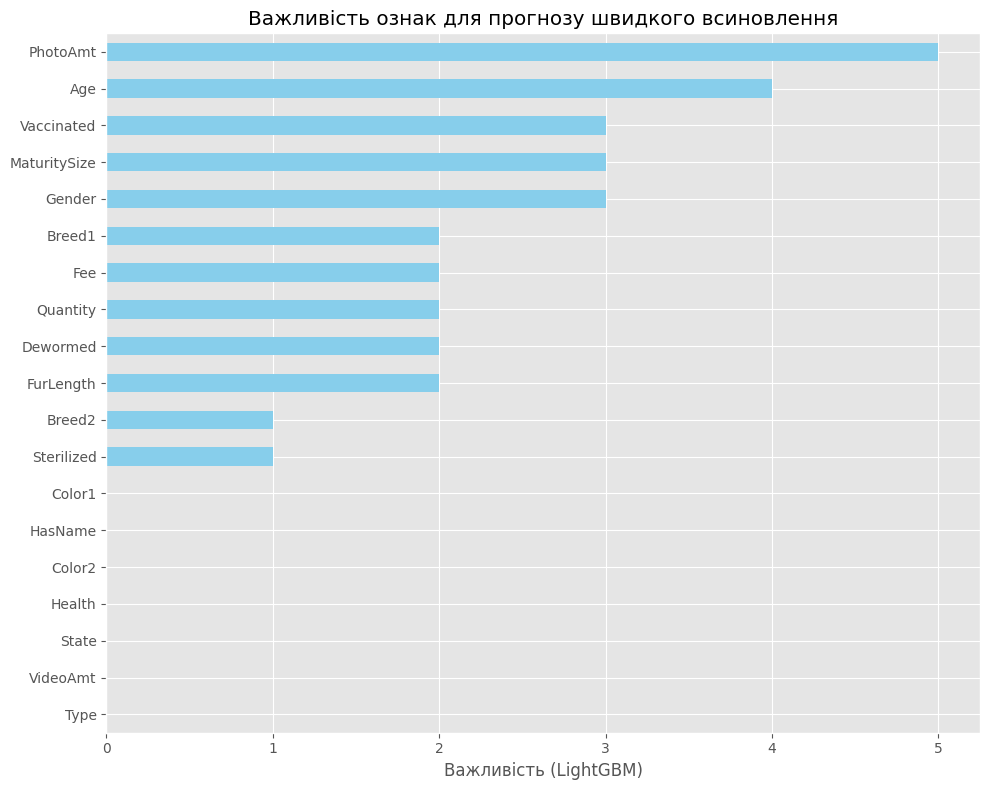

In [41]:
import matplotlib.pyplot as plt

# Побудова графіка важливості ознак
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=True)

plt.figure(figsize=(10, 8))
importances.plot(kind='barh', color='skyblue')
plt.title('Важливість ознак для прогнозу швидкого всиновлення')
plt.xlabel('Важливість (LightGBM)')
plt.tight_layout()
plt.show()

Портрет тварини, яка має найвищий шанс на швидке всиновлення

In [42]:
# Виводимо "портрет" — характеристики з групи AdoptionSpeed == 0
quick = all_data[all_data['AdoptionSpeed'] == 0]

ideal_pet = {}
for col in features:
    try:
        ideal_pet[col] = quick[col].mode()[0]
    except:
        ideal_pet[col] = quick[col].mean()

# Візуальний портрет
print("Портрет тварини з найвищим шансом на швидке всиновлення:\n")
for key, value in ideal_pet.items():
    print(f"{key:15}: {value}")


Портрет тварини з найвищим шансом на швидке всиновлення:

Type           : 2
Age            : 2
Breed1         : 266
Breed2         : 0
Gender         : 2
Color1         : 1
Color2         : 0
MaturitySize   : 2
FurLength      : 1
Vaccinated     : 2
Dewormed       : 1
Sterilized     : 2
Health         : 1
Quantity       : 1
Fee            : 0
State          : 41326
VideoAmt       : 0
PhotoAmt       : 2.0
HasName        : 1


Знаходимо моду фіч серед швидко усиновлених

In [43]:
quick = all_data[all_data['AdoptionSpeed'] == 0]

# Ознаки для точного фільтрування
important_cols = ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'FurLength',
                  'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'HasName']

# Знаходимо модальні значення для кожної ознаки
ideal_profile = {}
for col in important_cols:
    ideal_profile[col] = quick[col].mode()[0]

# Фільтруємо тварин, які точно збігаються з профілем
matched = quick.copy()
for col, value in ideal_profile.items():
    matched = matched[matched[col] == value]

print(f"Знайдено {len(matched)} тварин, які ідеально відповідають типажу.")


Знайдено 1 тварин, які ідеально відповідають типажу.


Показуємо фотографію

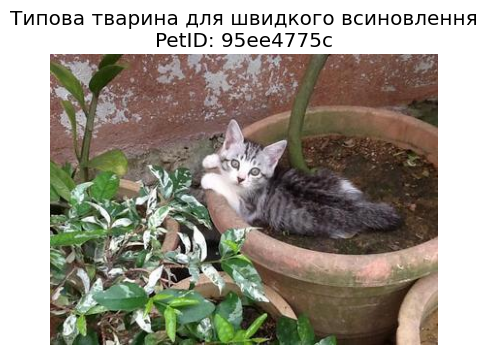

In [44]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Беремо перший PetID із відповідних
pet_id = matched.iloc[0]['PetID']
img_path = f"/kaggle/input/petfinder-adoption-prediction/train_images/{pet_id}-1.jpg"

# Перевірка наявності файлу
if os.path.exists(img_path):
    img = Image.open(img_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Типова тварина для швидкого всиновлення\nPetID: {pet_id}")
    plt.axis('off')
    plt.show()
else:
    print("Зображення не знайдено:", img_path)


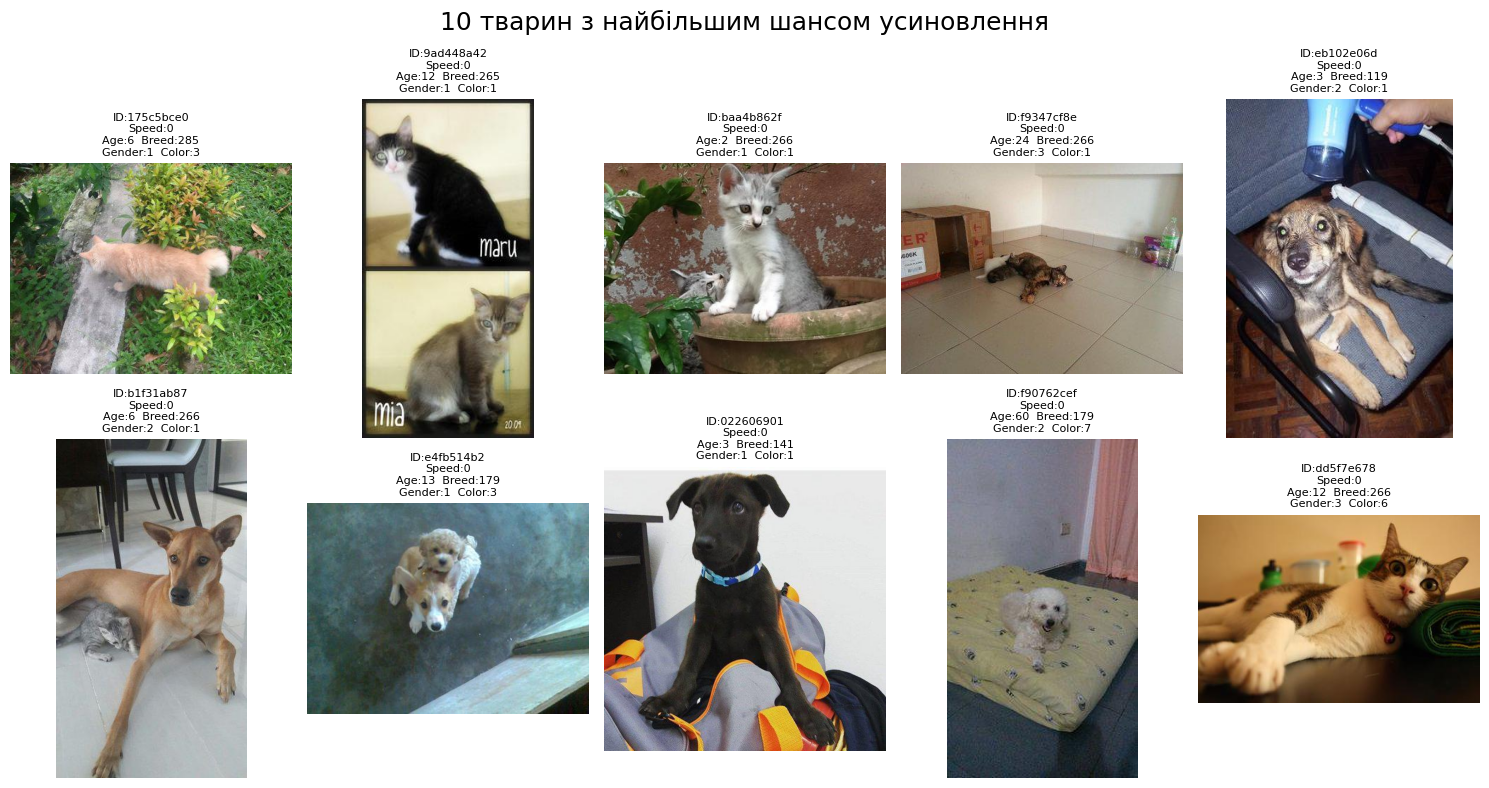

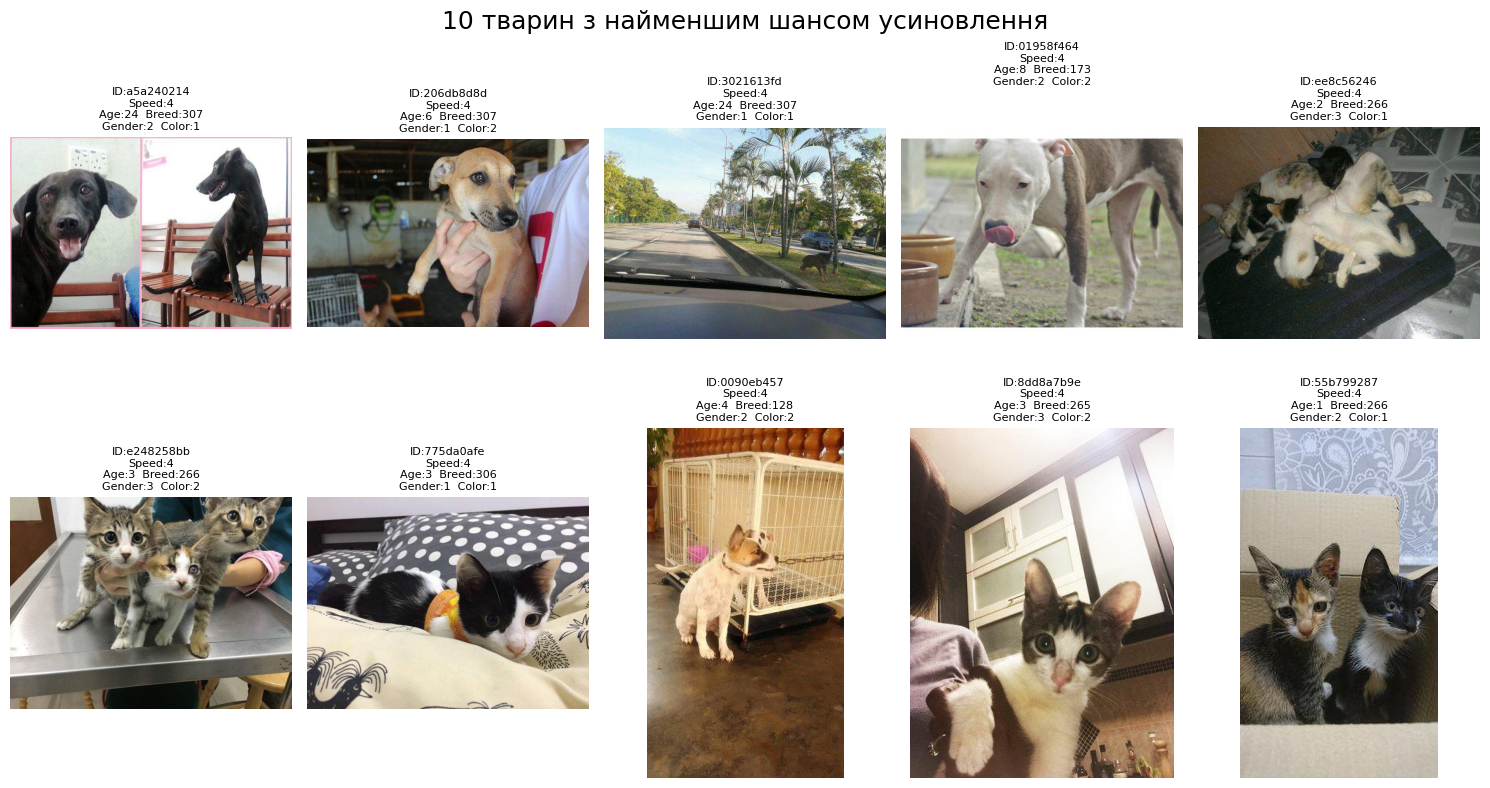

In [45]:
# Функція для відображення фото з параметрами
def show_pets_with_info(df, title):
    plt.figure(figsize=(15, 8))
    plt.suptitle(title, fontsize=18)

    for i, (_, row) in enumerate(df.iterrows()):
        pet_id = row["PetID"]
        img_path = f"/kaggle/input/petfinder-adoption-prediction/train_images/{pet_id}-1.jpg"

        plt.subplot(2, 5, i+1)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.imshow(img)
        else:
            plt.text(0.5, 0.5, "No image", ha='center', va='center')

        # Параметри
        info = (
            f"ID:{pet_id}\n"
            f"Speed:{row['AdoptionSpeed']}\n"
            f"Age:{row['Age']}  Breed:{row['Breed1']}\n"
            f"Gender:{row['Gender']}  Color:{row['Color1']}"
        )
        plt.title(info, fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Сортуємо по AdoptionSpeed
fastest = train.sort_values(by="AdoptionSpeed", ascending=True).head(10)
slowest = train.sort_values(by="AdoptionSpeed", ascending=False).head(10)

# Відображаємо
show_pets_with_info(fastest, "10 тварин з найбільшим шансом усиновлення")
show_pets_with_info(slowest, "10 тварин з найменшим шансом усиновлення")


In [46]:

print("training data shape:", train.shape)
print("submission data shape:", submit.shape)

submit['HasName'] = submit['Name'].notnull().astype(int)
X_test = submit[features]

y_pred = model.predict(X_test)

submission = pd.DataFrame({
    "PetID": submit["PetID"],
    "AdoptionSpeed": y_pred  
})

submission.to_csv("submission.csv", index=False, header=True)
print(submission.head(10))
counts = train['AdoptionSpeed'].value_counts().reset_index()
counts.columns = ['AdoptionSpeed', 'Count']
print(counts)

training data shape: (14993, 26)
submission data shape: (3972, 23)
       PetID  AdoptionSpeed
0  e2dfc2935              0
1  f153b465f              0
2  3c90f3f54              0
3  e02abc8a3              0
4  09f0df7d1              0
5  0487529d4              0
6  bae7c4b1c              0
7  548bcf206              0
8  0f82cea1e              0
9  a3787f15e              0
   AdoptionSpeed  Count
0              4   4197
1              2   4037
2              3   3259
3              1   3090
4              0    410


Summury:

1. Основні метрики при виборі тварини: фото, вік та тип.
2. Тварини мають найменьший шанс знайти домівку,якщо мають негарне фото, або фото, де вони зображені з додатковими тваринами, а також якщо параметри заповнені не повністю (наприклад не вказано стать).
3. Результати по метрикам
Quadratic Kappa без текстових ознак: 0.3684
Quadratic Kappa з текстовими ознаками: 0.3170
Тобто додавання текстових ознак знизило якість передбачення. Це означає, що:
- або текстові фічі містять шум,
- або вони були закодовані так, що модель не змогла їх ефективно використати,
- або вони створюють кореляцію з іншими ознаками, погіршуючи загальну стабільність.
4. Аналіз train_loss та val_loss
- train_loss стабільно знижується і доходить до ~0.037.
- val_loss теж знижується, але дуже повільно: початок — ~0.112, кінець — ~0.118.
Різниця між train і val на фінальних ітераціях досить помітна (0.037 vs 0.118), що свідчить про перенавчання.
5. Ознаки перенавчання:
Модель на тренуванні працює значно краще, ніж на валідації.
val_loss починає знижуватись до певного моменту, а потім майже стоїть або злегка зростає після ~15–20 епох.
Це типовий сигнал, що потрібно або зменшувати кількість ітерацій (early stopping), або посилювати регуляризацію.
6. Відповідні зміни:
Використано early stopping по val_loss (early_stopping_rounds=50) щоб уникнути перенавчання.
Спробував збільшити регуляризацію (lambda_l1, lambda_l2, min_data_in_leaf).
Перевірив важливість ознак (model.feature_importance()), щоб оцінити, які фічі вносять найбільше шуму.
7. Найкраща валідаційна втрата була на 19-й ітерації — 0.10829.
Після цього значення валідаційного loss повільно зростає, що вказує на початок overfitting.
Тобто, оптимально було б зупинити навчання приблизно після 19-ї ітерації, щоб уникнути погіршення узагальнення моделі.
8. Результат після змін: суттєво змінилися метрики оцінки, якісне та гарне фото змістилося на позицію №1, що доводить висновок, що люди "обирають очима". Частина метрик суттєво втратила свій вплив на результ.
9. З урахуванням підсвідомих дій користувачів при виборі тварини хотілося би додати дані про місце розмціщення даних про тварину при пошуку/виборі та частоту додавання тварини до статусу "favorite". Нажаль дана інформація відсутня в датасеті. 
    